# Hyperbolic matrix factorization final project

In [1]:
import numpy as np
import cupy as cp
import pandas as pd
from scipy.sparse import csr_matrix as numpy_csr_matrix
from cupy.sparse import csr_matrix as cupy_csr_matrix
import matplotlib.pyplot as plt
from hyperbolic_mf import HyperbolicMF, NegativeSampler

In [2]:
%load_ext autoreload
%autoreload 2

## Test on movie data

In [3]:
from movie_utils import *

In [4]:
data_dir = '/app/datasets/moviedata/'

In [5]:
# def generate_interactions_matrix(data, data_description, rebase_users=False, backend=np):
#     '''
#     Convert pandas dataframe with interactions into a sparse matrix.
#     Allows reindexing user ids, which help ensure data consistency
#     at the scoring stage (assumes user ids are sorted in scoring array).
#     '''
#     n_users = data_description['n_users']
#     n_items = data_description['n_items']
#     # get indices of observed data
#     user_idx = data[data_description['users']].values
#     if rebase_users:
#         user_idx, user_index = pd.factorize(user_idx, sort=True)
#         n_users = len(user_index)
#     user_idx = backend.array(user_idx)
#     item_idx = backend.array(data[data_description['items']].values)
#     feedback = backend.array(data[data_description['feedback']].values)
#     # construct rating matrix
#     if backend == np:
#         return (numpy_csr_matrix((backend.ones(feedback.shape), (user_idx, item_idx)), shape=(n_users, n_items)), 
#                 numpy_csr_matrix((feedback, (user_idx, item_idx)), shape=(n_users, n_items)))
#     else:
#         # print(feedback.shape, user_idx.shape, item_idx.shape)
#         return (cupy_csr_matrix((backend.ones(feedback.shape), (user_idx, item_idx)), shape=(n_users, n_items)), 
#                 cupy_csr_matrix((feedback, (user_idx, item_idx)), shape=(n_users, n_items)))

In [6]:
# def timepoint_split(data, time_split_q=0.95):
#     """
#     Split data into training, testset, and holdout datasets based on a timepoint split
#     and according to the `warm-start` evaluation strategy.

#     Parameters
#     ----------
#     data : pd.DataFrame
#         The input dataset containing columns `userid`, `movieid`, and `timestamp`.
#     time_split_q : float, optional
#         The quantile value used to split the dataset based on the `timestamp` column.
#         Default is 0.95.

#     Returns
#     -------
#     Tuple[pd.DataFrame, pd.DataFrame, pd.DataFrame]
#         A tuple of three pandas DataFrames: training, testset, and holdout.
#         `training` is a subset of `data` used for training the recommender system.
#         `testset` is a subset of `data` used for generating recommendations for the test users.
#         `holdout` is a subset excluded from `testset` containing only the most recent interactions for each test user.

#     Notes
#     -----
#     The function splits the input `data` into three subsets: `training`, `testset`, and `holdout`.
#     The split is performed based on the `timestamp` column of `data`, using `time_split_q` as the quantile value.
#     The `holdout` dataset contains only the immediate interactions following the fixed timepoint for each test user from the `testset`.
#     The set of users in `training` is disjoint with the set of users in the `testset`, which implements the `warm-start` scenario.
#     """    
#     timepoint = data.timestamp.quantile(q=time_split_q, interpolation='nearest')
#     test_ = data.query('timestamp >= @timepoint')
#     rest_ = data.drop(test_.index)
#     holdout_ = (
#         test_
#         .sort_values('timestamp')
#         .drop_duplicates(subset=['userid'], keep='first')
#     )
#     # the holdout dataframe contains interactions closest to certain timepoint from the right,
#     # i.e., the corresponding items are the first in each test user profile after this timepoint
#     training = rest_.query('userid not in @holdout_.userid')
#     train_items = training.movieid.unique()
#     testset_ = rest_.query('userid in @holdout_.userid and movieid in @train_items')
#     test_users = testset_.userid.unique()
#     holdout = holdout_.query(
#         # if user is not in `test_users` then no evluation is possible,
#         # if item is not in `train_items` it's cold start -> must be excluded
#         'userid in @test_users and movieid in @train_items'
#     ).sort_values('userid')
#     testset = testset_.query(
#         # make sure testset and holdout contain the same set of users
#         'userid in @holdout.userid'
#     ).sort_values('userid')
#     return training, testset, holdout

In [7]:
training_source = pd.read_csv(data_dir + 'training')
testset_source = pd.read_csv(data_dir + 'testset')

In [8]:
training_source.head(5)

,userid,movieid,rating,timestamp
0,158862,1600,4.0,978307288
1,49693,9102,4.0,985466347
2,65237,2408,3.0,978308050
3,82765,2590,2.0,985139361
4,120946,285,2.0,978308465


In [9]:
# def save_solution(recs_array, useridx, itemidx, filepath):
#     """
#     Save a solution for Kaggle competition in the required format.

#     Parameters 
#     ----------
#     recs_array (numpy.ndarray): Array of recommended items. 
#     useridx (pandas.Index): Test user indices in the original (source) representation. 
#     itemidx (pandas.Index): Mapping from internal to orignial representation of item indices. 
#     filepath (str): Path to save the solution file. 

#     Returns
#     -------
#     None: The function saves the solution file in the csv format at the specified path. 

#     Notes
#     -----
#     The code creates a dataframe containing user IDs and a list of recommended items for each user.
#     It then melts the dataframe so that each row contains one recommended item per user.
#     Finally, it saves the melted dataframe to a file at the specified filepath.
#     """
#     rec_items = itemidx.take(recs_array).values
#     solution = pd.DataFrame({
#         'userid': useridx,
#         'movieid': [list(recs) for recs in rec_items]
#     })
#     sol_melt = solution.set_index('userid')['movieid'].explode().reset_index()
#     sol_melt.to_csv(filepath, index=False)

In [10]:
# def reindex_data(data, data_index, fields=None):
#     '''
#     Reindex provided data with the specified index mapping.
#     By default, will take the name of the fields to reindex from `data_index`.
#     It is also possible to specify which field to reindex by providing `fields`.
#     '''
#     if fields is None:
#         fields = data_index.keys()
#     if isinstance(fields, str): # handle single field provided as a string
#         fields = [fields]
#     for field in fields:
#         entity_name = data_index[field].name
#         new_index = data_index[field].get_indexer(data[entity_name])
#         data = data.assign(**{f'{entity_name}': new_index}) # makes a copy of dataset!
#     return data

# def to_numeric_id(data, field):
#     '''
#     Get new contiguous index by converting the data field
#     into categorical values.
#     '''
#     idx_data = data[field].astype("category")
#     idx = idx_data.cat.codes
#     idx_map = idx_data.cat.categories.rename(field)
#     return idx, idx_map

# def transform_indices(data, users, items):
#     '''
#     Reindex columns that correspond to users and items.
#     New index is contiguous starting from 0.
#     '''
#     data_index = {}
#     for entity, field in zip(['users', 'items'], [users, items]):
#         new_index, data_index[entity] = to_numeric_id(data, field)
#         data = data.assign(**{f'{field}': new_index}) # makes a copy of dataset!
#     return data, data_index

In [11]:
# def transform_data(train, test, ho=None, userid='userid', itemid='movieid'):
#     train_val, data_index = transform_indices(train, userid, itemid)
#     test_val = reindex_data(test, data_index, fields='items')
#     if ho is None:
#         return train_val, test_val, data_index
#     hold_val = reindex_data(ho, data_index, fields='items')
#     return train_val, test_val, hold_val, data_index

In [12]:
# def model_evaluate(recommended_items, holdout, holdout_description, topn=10):
#     itemid = holdout_description['items']
#     holdout_items = holdout[itemid].values
#     assert recommended_items.shape[0] == len(holdout_items)
#     hits_mask = recommended_items[:, :topn] == holdout_items.reshape(-1, 1)
#     # HR calculation
#     hr = np.mean(hits_mask.any(axis=1))
#     # MRR calculation
#     n_test_users = recommended_items.shape[0]
#     hit_rank = np.where(hits_mask)[1] + 1.0
#     mrr = np.sum(1 / hit_rank) / n_test_users
#     # coverage calculation
#     n_items = holdout_description['n_items']
#     cov = np.unique(recommended_items).size / n_items
#     ndcg = (1 / np.log2(hit_rank + 1)).sum() / recommended_items.shape[0]
#     return hr, mrr, cov, ndcg

In [13]:
train_val, test_val, hold_val = timepoint_split(training_source)

In [14]:
train_val, test_val, hold_val, data_index = transform_data(train_val, test_val, hold_val)

In [15]:
data_description = {
    'users': 'userid',
    'items': 'movieid',
    'feedback': 'rating',
    'n_users': len(data_index['users'].unique()),
    'n_items': len(data_index['items'].unique())
}

Check that the prior is really pseudo-hyperbolic

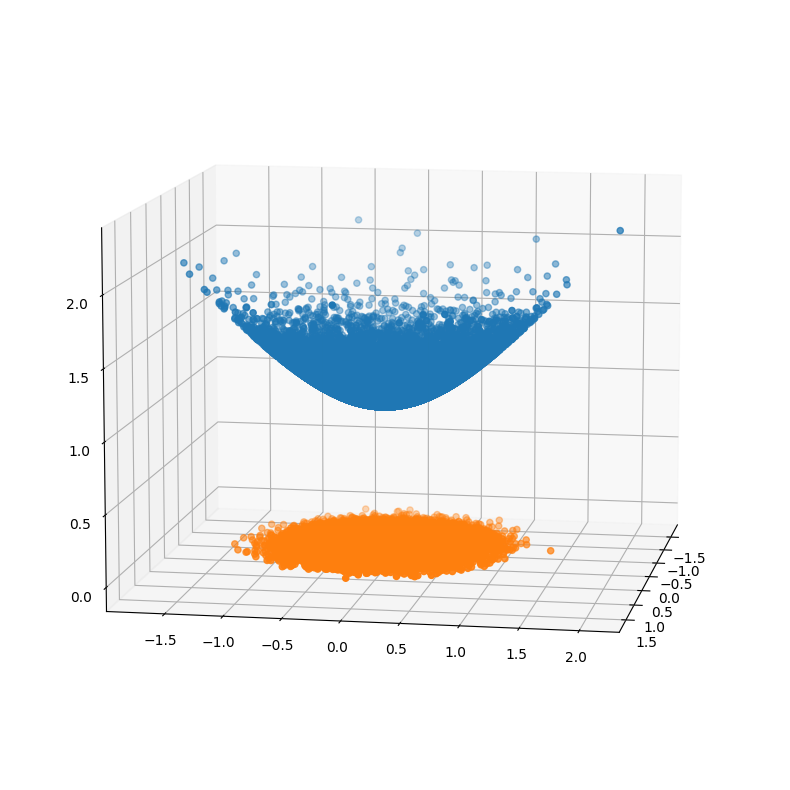

In [16]:
fig, ax = plt.subplots(subplot_kw={"projection": "3d"}, figsize=(10, 10))

model = HyperbolicMF(sigma_U=1e-4, sigma_V=1e-4)
points, x = model.draw_from_pseudo_hyperbolic_gaussian((100000,3), 0.3, return_gauss=True)
ax.view_init(10, 10)
ax.scatter(points[:, 0], points[:, 1], points[:, 2])
ax.scatter(x[:, 0], x[:, 1], x[:, 2])

In [25]:
# n_iters = [50, 100, 150, 200, 250, 300, 350, 400]
dims = [3, 5, 10, 20, 30, 50]
# sigmas = [1e-3, 1e-2, 1e-1, 1, 1.2]
# lrs = [1e-6, 1e-5, 1e-5, 1e-5, 1e-5]
results = []
all_losses = []

train_interations, train_data = generate_interactions_matrix(train_val, data_description, False, backend=cp)
test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)

# n_users, dim = model.U.shape

for i, d in enumerate(dims):

    model = HyperbolicMF(sigma_U=1e-2, sigma_V=1e-2, backend=cp)
    losses, U_n, V_n = model.fit(train_interations, None, num_epochs=100, learning_rate=1e-5, decomposition_rank=d, batch_size=200, seed=None)
    
    test_user_inds, U_norm_test = model.add_unknown_user(test_interations, None, n_iters=100, lr=1e-5, batch_size=200) # Add unknown users to user_matrix of our model
    preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
    downvote_seen_items(preds, test_val, data_description)
    # preds = preds * (1 - test_interations)
    preds = cp.argsort(preds)[:, -20:].get()

    hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20) # The score upper the first baseline without choosing hyperparameters for not fully tuned model
    print(f'Decomp rank: {d} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')
    results.append((hr, mrr, cov, ndcg))
    all_losses.append(losses)

fig, axs = plt.subplots(1, 5, figsize=(40, 8))
results = np.array(results)
axs[0].set_title('HR')
axs[0].plot(dims, results[:, 0])
axs[0].grid(True)
axs[1].set_title('MRR')
axs[1].plot(dims, results[:, 1])
axs[1].grid(True)
axs[2].set_title('COV')
axs[2].plot(dims, results[:, 2])
axs[2].grid(True)
axs[3].set_title('NDCG')
axs[3].plot(dims, results[:, 3])
axs[3].grid(True)
axs[4].set_title('Loss')
for i in range(len(all_losses)):
    axs[4].plot(all_losses[i], label=f'Decomposition rank: {dims[i]}')
axs[4].grid(True)
axs[4].legend()
# plt.legend()

  0%|          | 0/100 [00:00<?, ?it/s]

Decomp rank: 3 	 HR@20: 0.0683 	 MRR@20: 0.0065 	 COV: 0.0172 	 NDCG@20: 0.0188


  0%|          | 0/100 [00:00<?, ?it/s]

KeyboardInterrupt: 

In [18]:
model = HyperbolicMF(sigma_U=1e-2, sigma_V=1e-2, backend=cp)
train_interations, train_data = generate_interactions_matrix(train_val, data_description, False, backend=cp)
losses = model.fit(train_interations, train_data, num_epochs=200, learning_rate=1e-5, decomposition_rank=20, batch_size=200)

test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)
test_user_inds = model.add_unknown_user(test_interations, test_data, n_iters=200, lr=1e-5, batch_size=50) # Add unknown users to user_matrix of our model
preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
preds = cp.argsort(preds)[:, -20:].get() # Get numpy ids of predictions

  0%|          | 0/200 [00:00<?, ?it/s]

TypeError: Implicit conversion to a NumPy array is not allowed. Please use `.get()` to construct a NumPy array explicitly.

In [21]:
test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)
test_user_inds, _ = model.add_unknown_user(test_interations, test_data, n_iters=200, lr=1e-5, batch_size=50) # Add unknown users to user_matrix of our model
preds = model.predict(test_user_inds.get(), np.arange(data_description['n_items'])) # Predict probabilities for unknown users
preds = cp.argsort(preds)[:, -20:].get() 

In [22]:
hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20) # The score upper the first baseline without choosing hyperparameters for not fully tuned model
print(f'HR@20: \t\t {hr} \n MRR@20: \t {mrr} \n COV: \t\t {cov} \n NDCG@20: \t {ndcg}')

HR@20: 		 0.050928699820251645 
 MRR@20: 	 0.005809770836334265 
 COV: 		 0.0021026072329688814 
 NDCG@20: 	 0.014797090055292728


In [ ]:
HR@20: 		 0.005392450569203115 
 MRR@20: 	 0.0004969133171074601 
 COV: 		 0.0747326685089511 
 NDCG@20: 	 0.0014660521635406713

In [23]:
train_val_f, test_val_f, data_index_f = transform_data(training_source, testset_source)

In [24]:
data_descr_test = {
    'users': data_index_f['users'].name,
    'items': data_index_f['items'].name,
    'feedback': 'rating',
    'n_users': len(data_index_f['users']),
    'n_items': len(data_index_f['items'])
}

In [30]:
# Fit model
train_test_interactions, train_test_data = generate_interactions_matrix(train_val_f, data_descr_test, False, backend=cp)
model = HyperbolicMF(sigma_U=1e-2, sigma_V=1e-2, backend=cp)
losses = model.fit(train_test_interactions, train_test_data, num_epochs=100, learning_rate=1e-5, decomposition_rank=20, batch_size=200)

  0%|          | 0/100 [00:00<?, ?it/s]

In [31]:
# Add unknown users to user_matrix
test_test_interactions, test_test_data = generate_interactions_matrix(test_val_f, data_descr_test, True, backend=cp)
test_user_inds, _ = model.add_unknown_user(test_test_interactions, test_test_data, n_iters=250, lr=1e-5, batch_size=200)

# Predict for known users
test_preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
downvote_seen_items(test_preds, test_val_f, data_descr_test)
test_preds = cp.argsort(test_preds)[:, -20:].get() # Get numpy ids of predictions

In [32]:
test_user_index = pd.Index(testset_source['userid'].drop_duplicates())

In [33]:
save_solution(test_preds, test_user_index, data_index_f['items'], '/app/datasets/moviedata/hypermf_skoltech_movierecs_preds.csv')

# Stochastic training

  0%|          | 0/1000 [00:00<?, ?it/s]

Decomp rank: 3 	 HR@20: 0.0036 	 MRR@20: 0.0003 	 COV: 0.1442 	 NDCG@20: 0.0010


  0%|          | 0/1000 [00:00<?, ?it/s]

Decomp rank: 5 	 HR@20: 0.0018 	 MRR@20: 0.0003 	 COV: 0.1454 	 NDCG@20: 0.0006


  0%|          | 0/1000 [00:00<?, ?it/s]

Decomp rank: 10 	 HR@20: 0.0012 	 MRR@20: 0.0001 	 COV: 0.1493 	 NDCG@20: 0.0003


  0%|          | 0/1000 [00:00<?, ?it/s]

Decomp rank: 20 	 HR@20: 0.0006 	 MRR@20: 0.0001 	 COV: 0.1451 	 NDCG@20: 0.0002


  0%|          | 0/1000 [00:00<?, ?it/s]

Decomp rank: 30 	 HR@20: 0.0000 	 MRR@20: 0.0000 	 COV: 0.1474 	 NDCG@20: 0.0000


  0%|          | 0/1000 [00:00<?, ?it/s]

Decomp rank: 50 	 HR@20: 0.0000 	 MRR@20: 0.0000 	 COV: 0.1450 	 NDCG@20: 0.0000


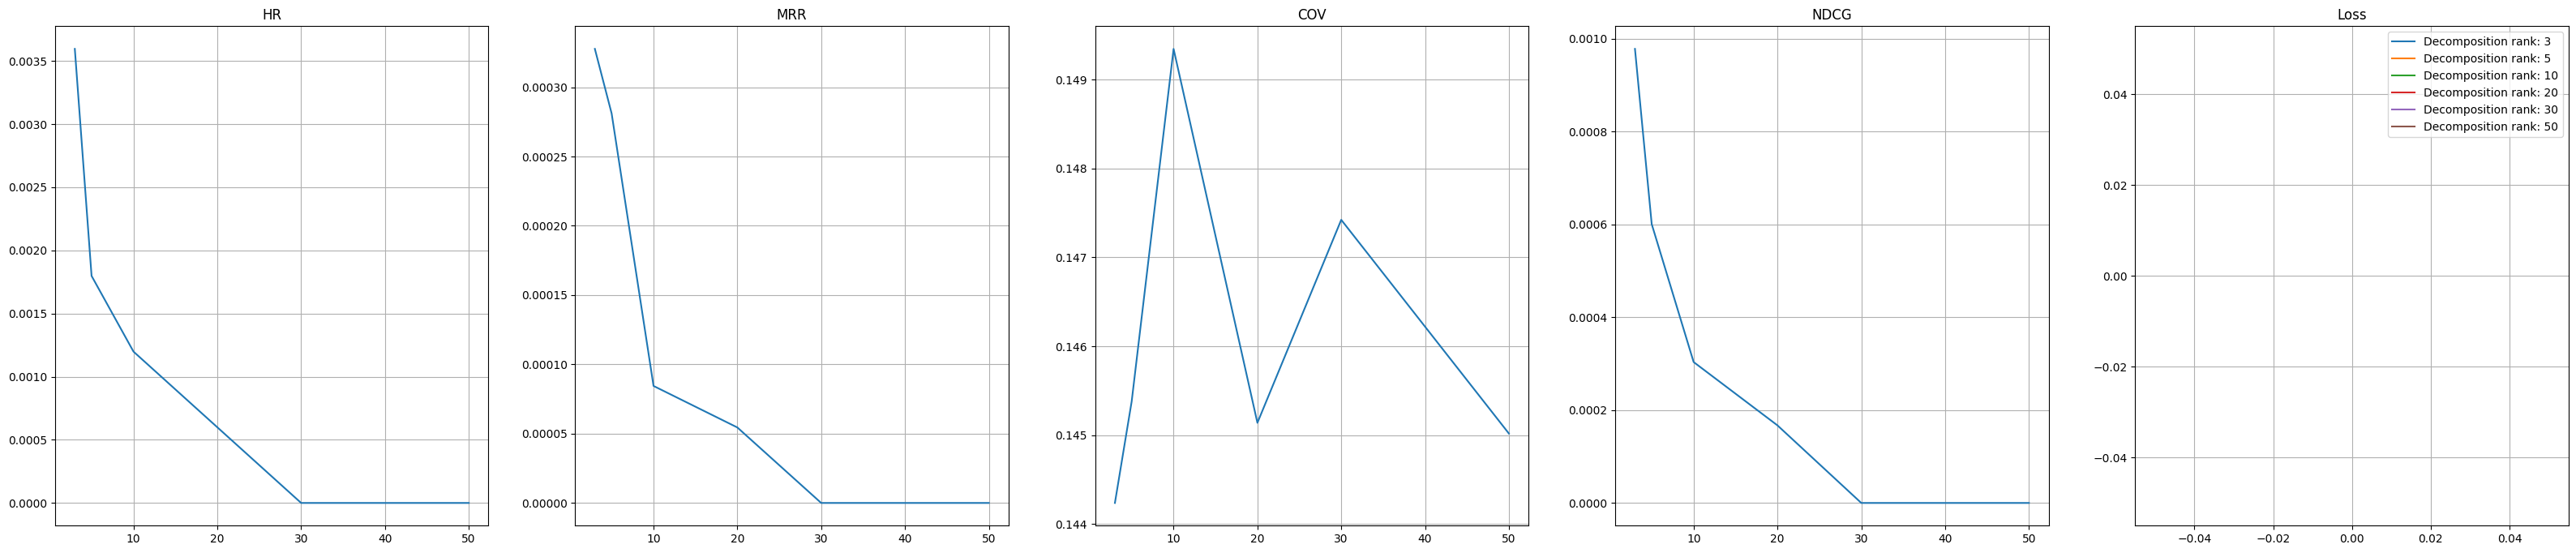

In [25]:
# n_iters = [50, 100, 150, 200, 250, 300, 350, 400]
dims = [3, 5, 10, 20, 30, 50]
batch_size = 2000
n_iters = 1000
lr = 1e-5
neg_samples_multiplier = 2
# sigmas = [1e-3, 1e-2, 1e-1, 1, 1.2]
# lrs = [1e-6, 1e-5, 1e-5, 1e-5, 1e-5]
results = []
all_losses = []

cp.random.seed(42)
np.random.seed(42)

# train_interations, train_data = generate_interactions_matrix(train_val, data_description, False, backend=cp)
# test_interations, test_data = generate_interactions_matrix(test_val, data_description, True, backend=cp)

# n_users, dim = model.U.shape

for i, d in enumerate(dims):

    model = HyperbolicMF(sigma_U=1e-2, sigma_V=1e-2, backend=cp)
    sampler = NegativeSampler(train_val, data_description, neg_samples_multiplier=neg_samples_multiplier, rebase_users=False)
    losses, U_n, V_n = model.fit_stochastic(sampler, num_iters=n_iters, learning_rate=lr, decomposition_rank=d, batch_size=batch_size, seed=None)
    
    test_sampler = NegativeSampler(test_val, data_description, neg_samples_multiplier=neg_samples_multiplier, rebase_users=True)
    test_user_inds, U_norm_test = model.add_unknown_user_stochastic(test_sampler, n_iters=n_iters, lr=lr, batch_size=batch_size) # Add unknown users to user_matrix of our model
    preds = model.predict(test_user_inds, np.arange(data_description['n_items'])) # Predict probabilities for unknown users
    downvote_seen_items(preds, test_val, data_description)
    preds = cp.argsort(preds)[:, -20:].get()

    hr, mrr, cov, ndcg = model_evaluate(preds, hold_val, data_description, topn=20) # The score upper the first baseline without choosing hyperparameters for not fully tuned model
    print(f'Decomp rank: {d} \t HR@20: {float(hr):.4f} \t MRR@20: {float(mrr):.4f} \t COV: {float(cov):.4f} \t NDCG@20: {float(ndcg):.4f}')
    results.append((hr, mrr, cov, ndcg))
    all_losses.append(losses)

fig, axs = plt.subplots(1, 5, figsize=(40, 8))
results = np.array(results)
axs[0].set_title('HR')
axs[0].plot(dims, results[:, 0])
axs[0].grid(True)
axs[1].set_title('MRR')
axs[1].plot(dims, results[:, 1])
axs[1].grid(True)
axs[2].set_title('COV')
axs[2].plot(dims, results[:, 2])
axs[2].grid(True)
axs[3].set_title('NDCG')
axs[3].plot(dims, results[:, 3])
axs[3].grid(True)
axs[4].set_title('Loss')
for i in range(len(all_losses)):
    axs[4].plot(all_losses[i], label=f'Decomposition rank: {dims[i]}')
axs[4].grid(True)
axs[4].legend()
# plt.legend()